In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torchvision import datasets, transforms
from utils import utils, plot_util
from trains import client, server

In [2]:
data_dir = '../../datas/cifar'
sample_id = 4
pretrain_dir_pre = '../../saves'
plot_dir = '../../plots'
pretrain_dirs = {
    'FedAvg'       : 'baselines/fed_avg',
    'Split-MS'     : 'baselines/sl_multi_server',
    'Split-SS'     : 'baselines/sl_single_server',
    #'CSE-FSL'       : 'cifar-iid-K3U3E1BR5-200-241121-001549',
    'CSE-FSL'      : 'cifar-iid-K3U3E1BR5-200-241202-104635',
    #'FSL-SAGE (WS)' : 'cifar-iid-K3U3E1BR5-200-241121-011651',
    #'FSL-SAGE (ours)'      : 'cifar-iid-K3U3E1BR5-200-241121-115013'
    'FSL-SAGE (ours)'      : 'FSL-SAGE_h5'
}
client_model_save_file = 'agg_client.pt'

pretrain_dirs = {
    k: os.path.join(pretrain_dir_pre, v, client_model_save_file)
    for k, v in pretrain_dirs.items()
}
print(pretrain_dirs)

{'FedAvg': '../saves/baselines/fed_avg/agg_client.pt', 'Split-MS': '../saves/baselines/sl_multi_server/agg_client.pt', 'Split-SS': '../saves/baselines/sl_single_server/agg_client.pt', 'CSE-FSL': '../saves/cifar-iid-K3U3E1BR5-200-241202-104635/agg_client.pt', 'FSL-SAGE (ours)': '../saves/FSL-SAGE_h5/agg_client.pt'}


In [3]:
# import test dataset
testRule = transforms.Compose([
    transforms.CenterCrop(24),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

testSet_view = datasets.CIFAR10(
    data_dir, train=False, download=True, transform=transforms.ToTensor()
)
testSet_comp = datasets.CIFAR10(
    data_dir, train=False, download=True, transform=testRule
)

Files already downloaded and verified
Files already downloaded and verified


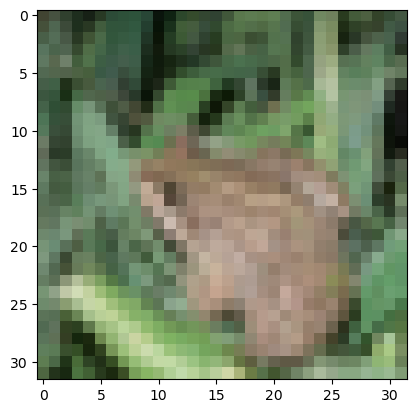

In [4]:
sample = testSet_view[sample_id][0]
label = testSet_view[sample_id][1]
plt.imshow(np.transpose(sample, (1, 2, 0)))

0.0 4.0005865
0.0 4.888189
0.0 3.200917
0.0 1.0523767
0.0 1.5030178


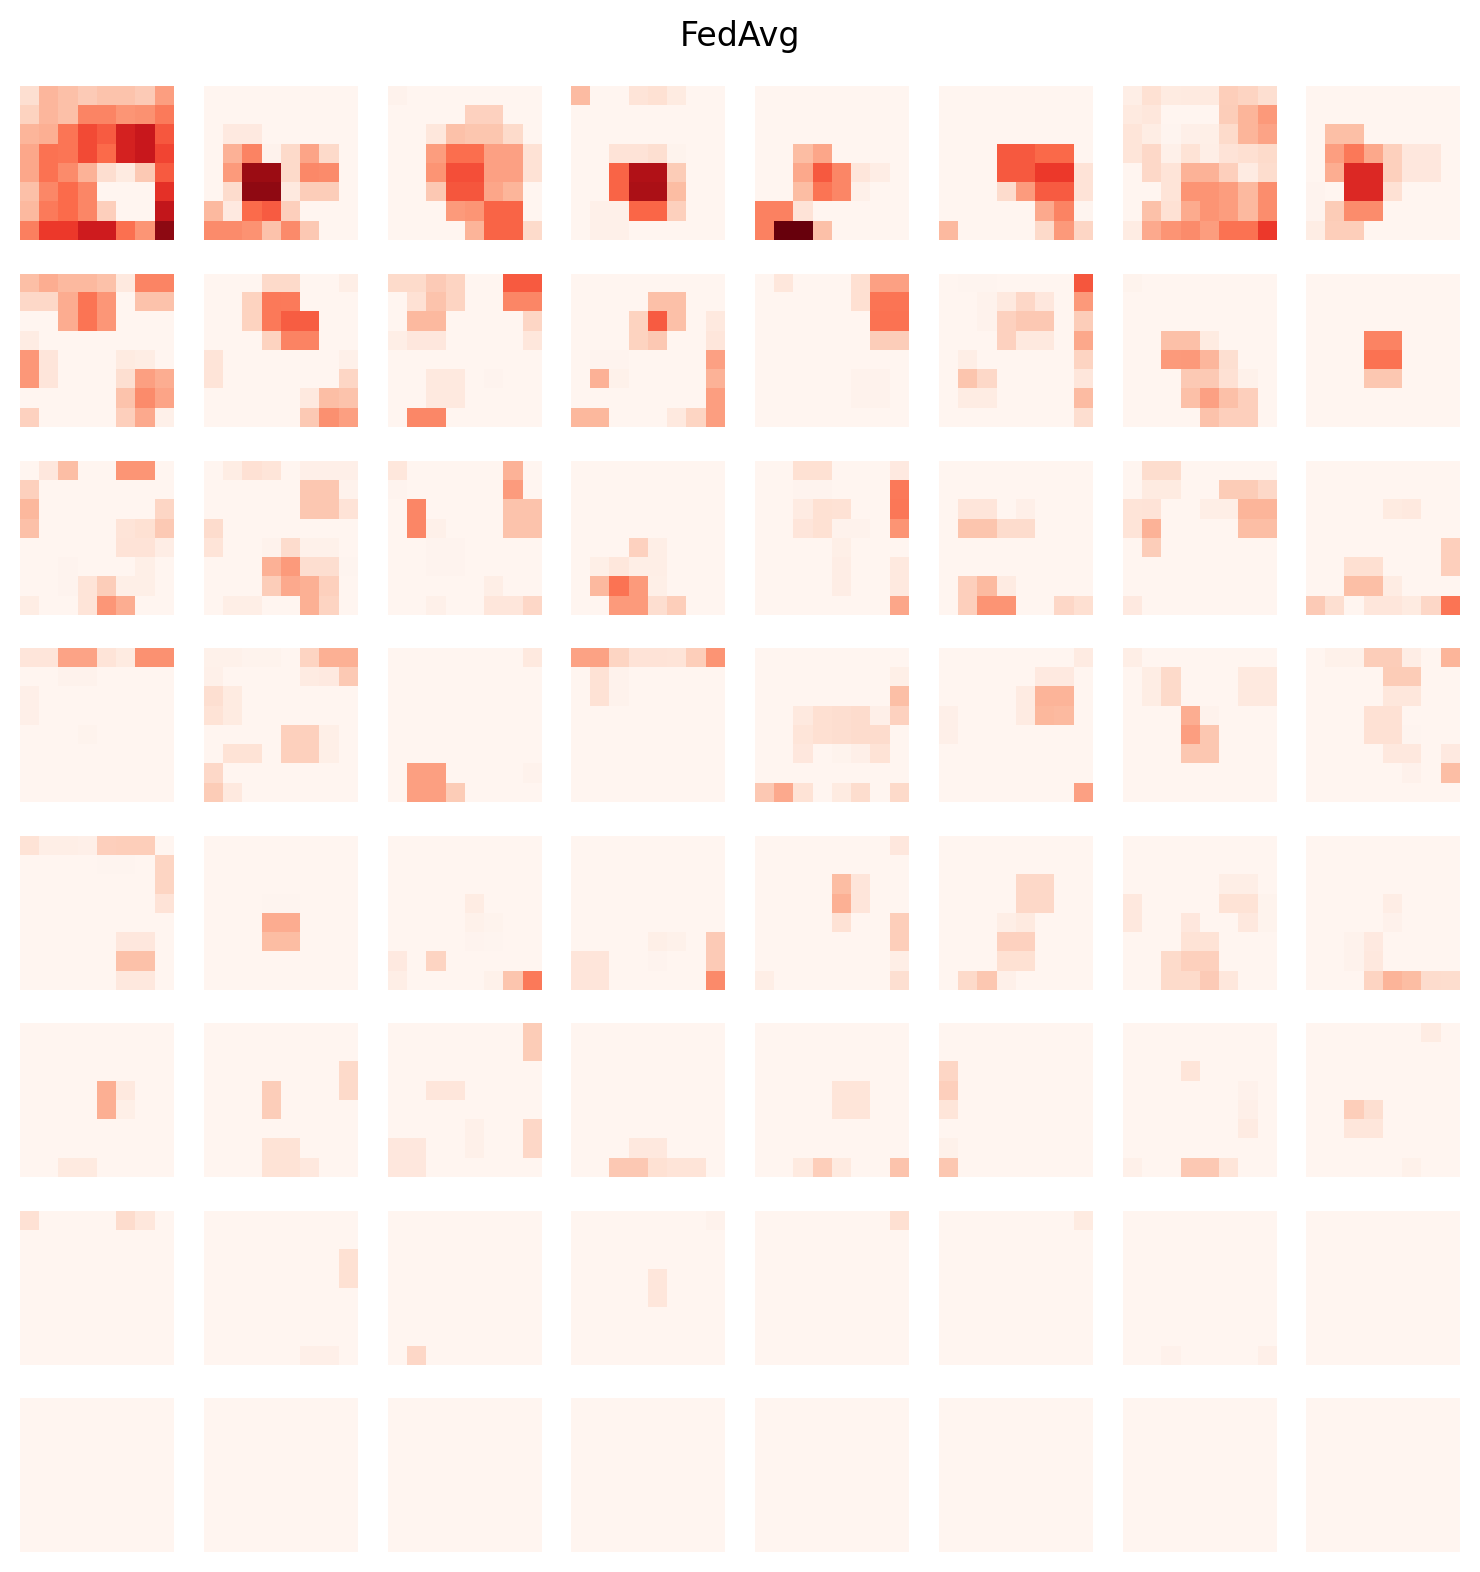

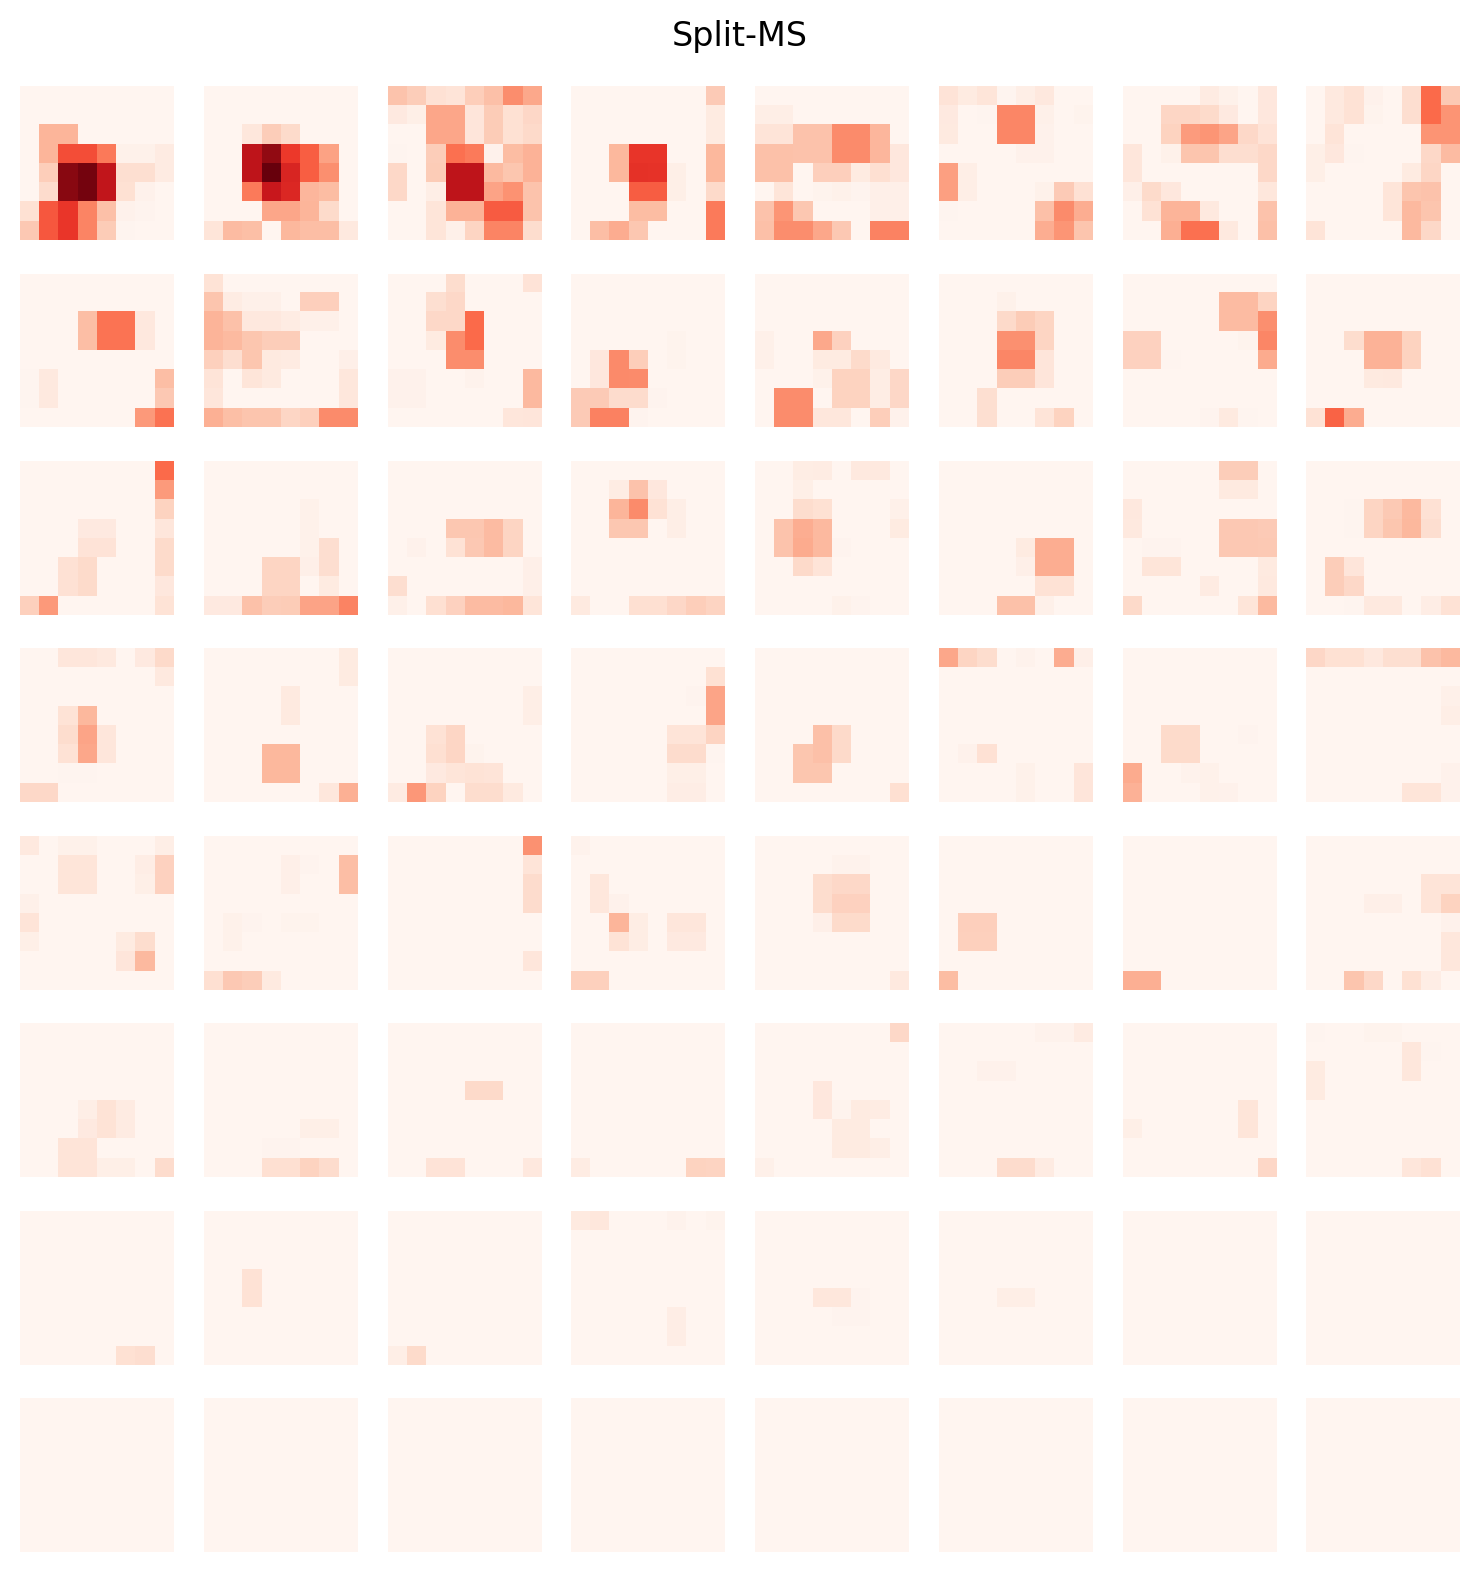

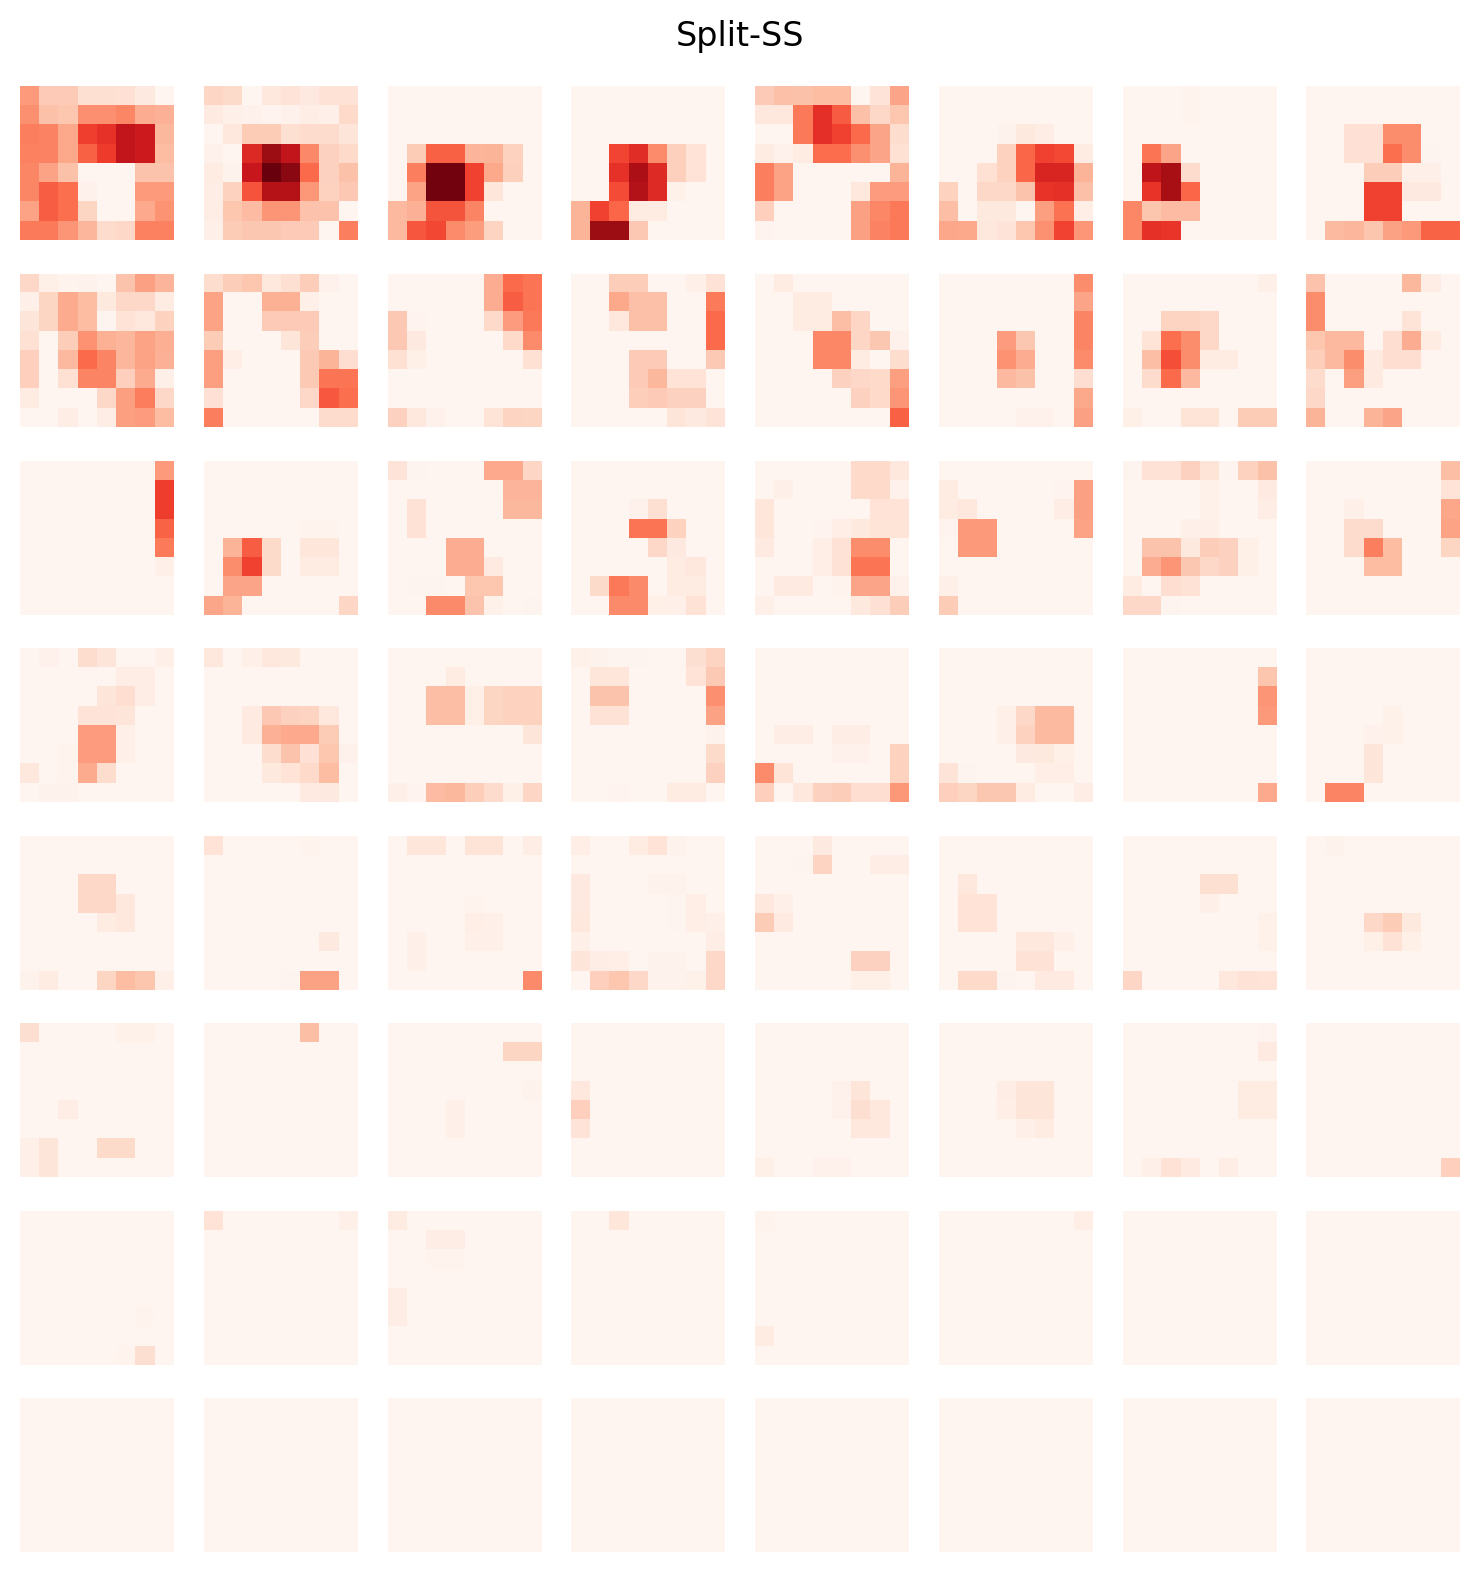

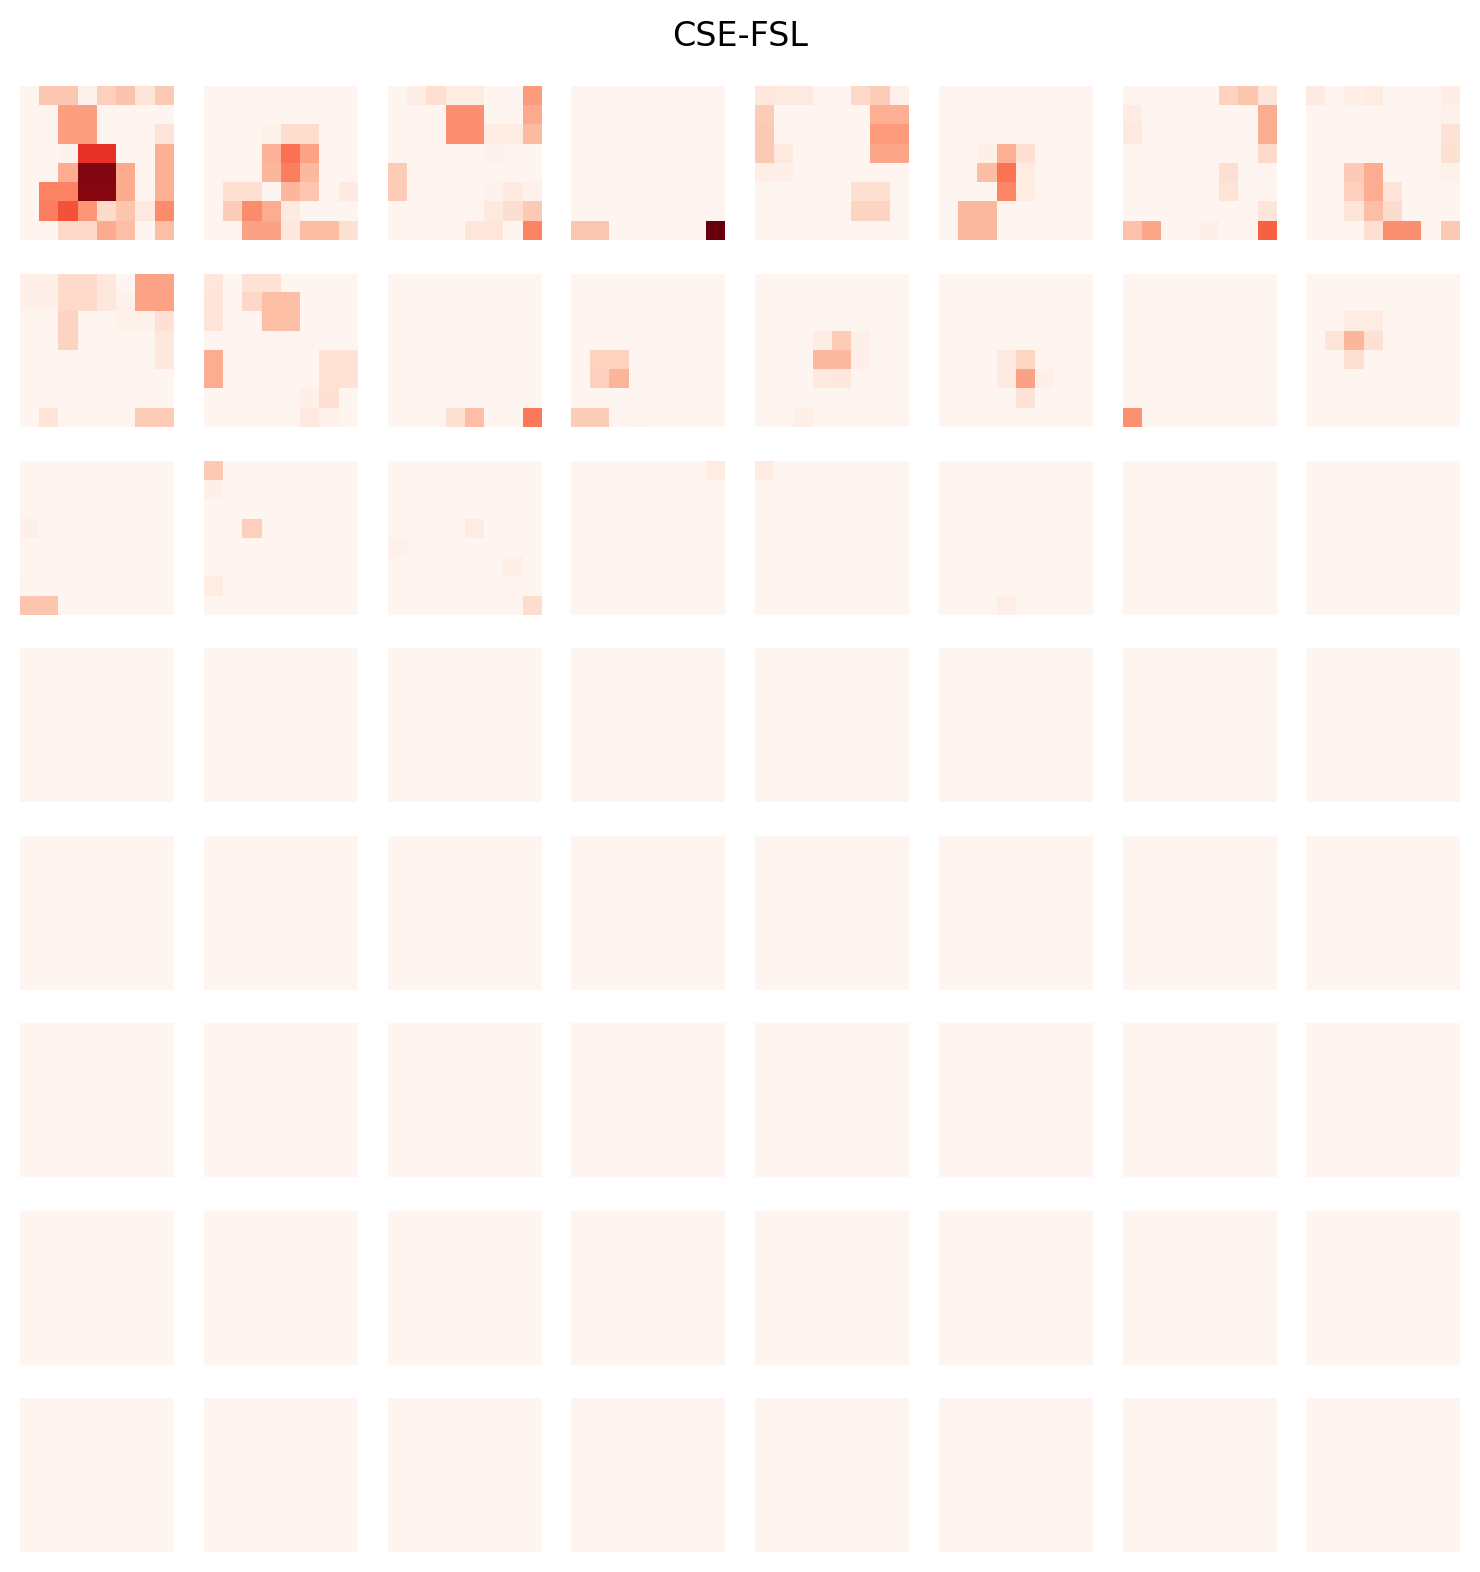

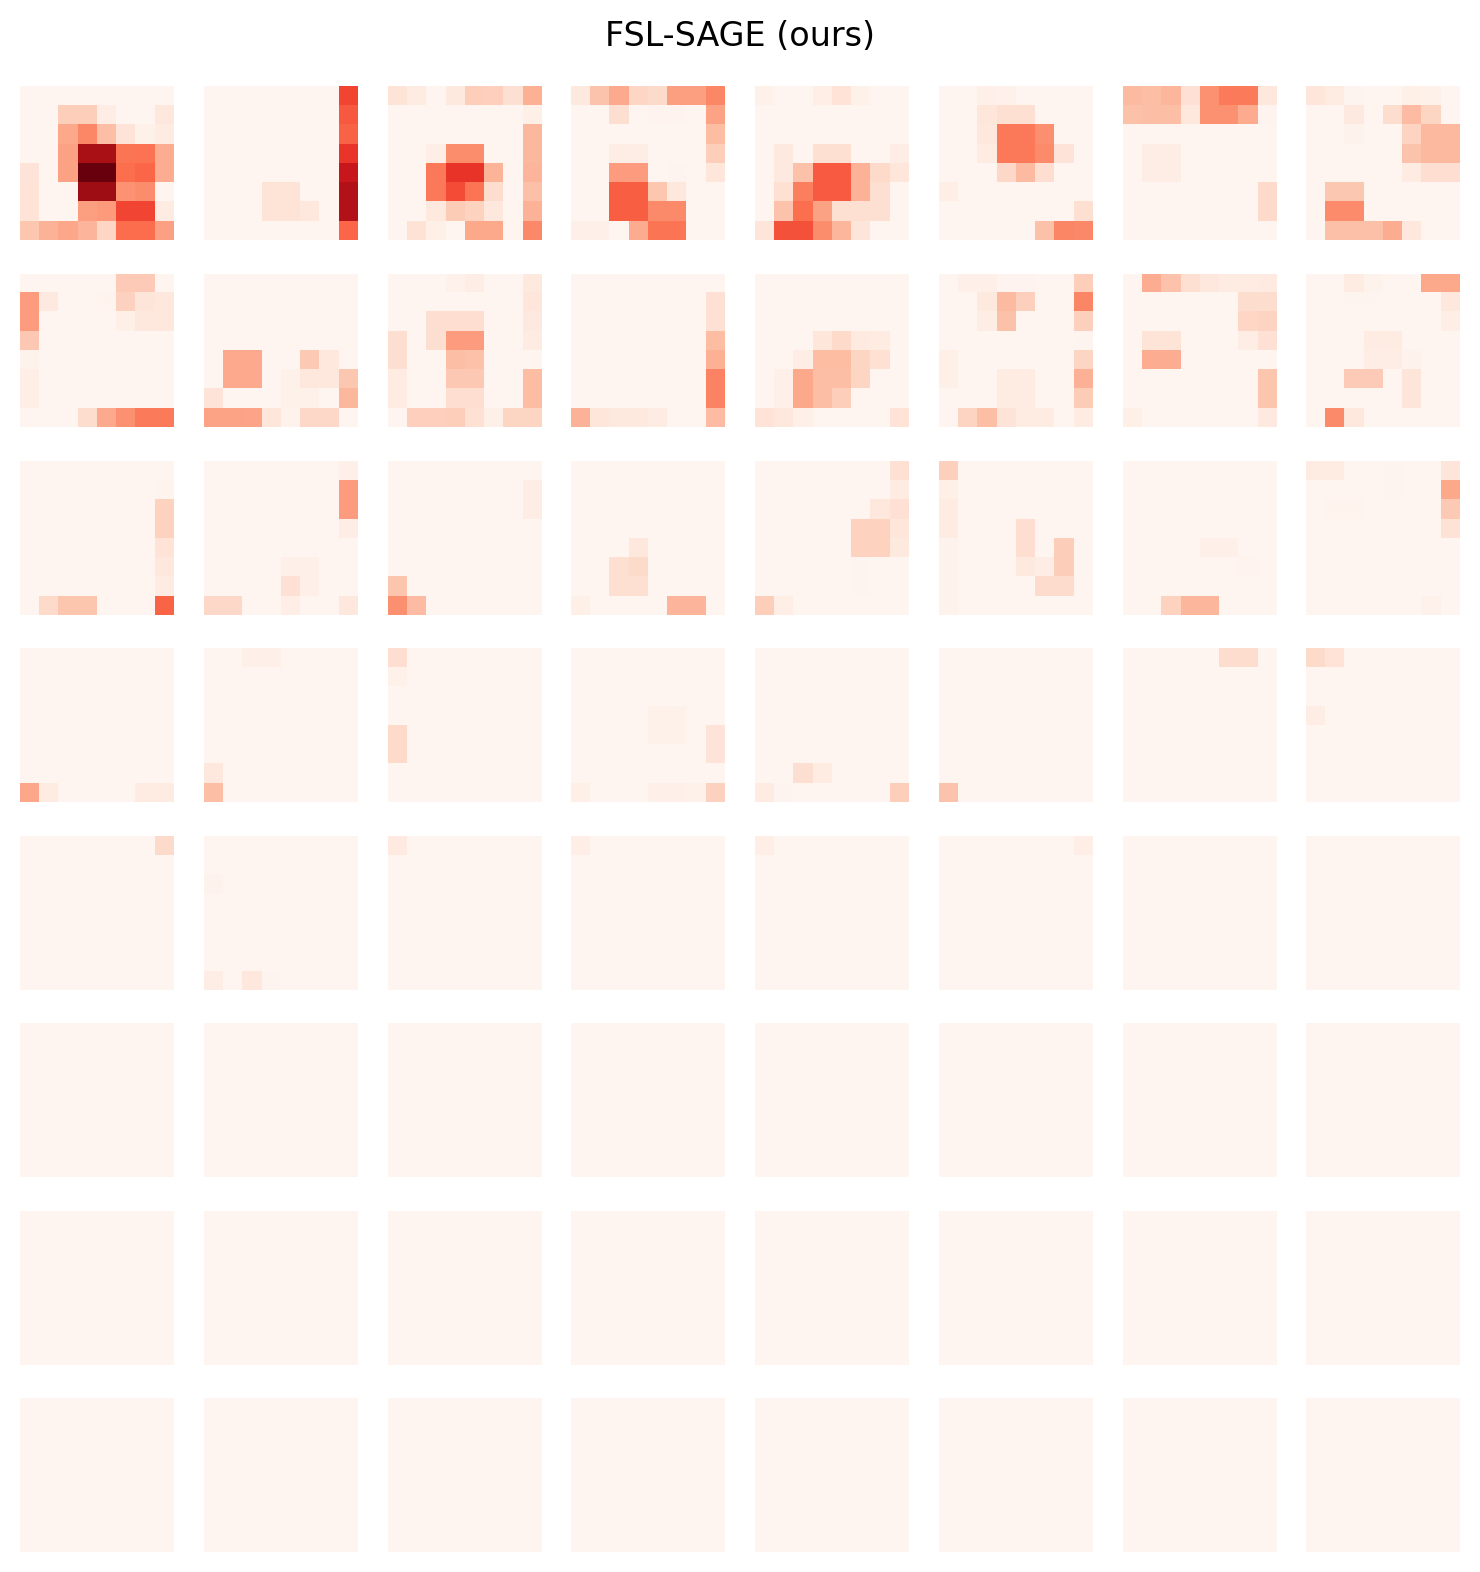

In [5]:
#server_model = server.Server_model_cifar()

for k, v in pretrain_dirs.items():

    if k == "FedAvg":
        comp_model = nn.Sequential(
            client.Client_model_cifar(), server.Server_model_cifar()
        )
        utils.load_model(comp_model, v)
        client_model = comp_model[0]
    else:
        client_model = client.Client_model_cifar()
        utils.load_model(client_model, v)

    cut_layer_acts = client_model.conv_forward(sample).detach().numpy()
    print(np.min(cut_layer_acts), np.max(cut_layer_acts))
    spectral_powers = np.sum(np.abs(cut_layer_acts)**2, axis=(1, 2))
    cut_layer_acts = cut_layer_acts[np.argsort(spectral_powers)[::-1], ...]
    fig, ax = plt.subplots(8, 8, figsize=[7.5, 8], dpi=200)
    fig.suptitle(k)
    for i, ax_ in enumerate(ax.flatten()):
        ax_.imshow(cut_layer_acts[i], cmap='Reds',
                   vmax=np.max(cut_layer_acts), vmin=np.min(cut_layer_acts))
        ax_.set_axis_off()
    plt.tight_layout()
    fig.savefig(f'{plot_dir}/activations_{k}.png', dpi=200)